# Flux balance analysis of Drosophila embryo development with Cobrapy

## Introduction
We apply COBRA and COBRApy for the perturbation experiments in Drosophila embryo based on `Flysilico` model with network reconstruction.

## Goals
According to three researches focusing on the metabolic process during the embryo development, we are now having the following goals to reproduce.

1. The injection of dATP results in the failure of the 11th cycle.
2. The increases of ETC and TCA related subunits switch the main stream of metabolic fluxes from fatty acid breakdown to aerobic glycolysis for hatching. 
3. The early-staged embryo is sensitive to hypoxia that results in lethal embryo but the later one is not (where is the shift occurring.) (reduce source, lower bound) (v)
4. The dERR and phosphofructokinase mutants cause the inhibition of glycolysis and lethal outcome. (v)
5. ASN as a nitrogen source (v)
6. The whole process produces 110 nmol of ATP which consists of 1.1 nmol of glycogen and 0.33 nmol of TAG. (v)
(use glycogen and TAG)
7. The ATP requirements of protein, RNA and DNA polymerization only use 10% energy budget.(create reactions related to ATP, set 0.1 to c metabolites) (v)
8. How much biomass is produced

In [1]:
# import essential packages
import cobra
import pandas as pd
import timeit
import time
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
from cobra.util.solver import linear_reaction_coefficients
from MatplotProp import CanvasStyle, PltProps
PltProps()

In [50]:
# Function for plotting out growth rate/flux curve against different level of oxygen.
def hypoxia_lines(xdata, title, lines_data, filename, ylabel='Growth rate'):
    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(111)
    ax1.plot(lines_data, lw=3, color='tomato')
    ax1.set_ylabel('{}'.format(ylabel))
    ax1.set_xlabel('Concentration of O2 in medium')
    ax1.set_xticks(np.linspace(0, len(xdata)-1, 6))
    ax1.set_xticklabels(np.round(np.linspace(0, max(xdata), 6), 3))
    ax1.set_title('{} flux'.format(title))
    x_min = ax1.get_xlim()
    y_min = ax1.get_ylim()
    CanvasStyle(ax1)
    plt.savefig(r"FBA_data/{}_lineplot.png".format(filename))
    plt.show()
    
# Function for plotting out heatmap with selected reactions.
def hypoxia_heatmap(xdata, model, title, target, heatmap_data, filename, ylabel='Flux'):
    fig = plt.figure(figsize=(25, 10))
    ax2 = fig.add_subplot(111)
    im = ax2.imshow(heatmap_data, cmap='RdBu')
    ticks = [model.reactions[i].id for i in range(
        len(model.reactions)) if model.reactions[i].id in target]
    ax2.set_yticks(2*np.arange(len(ticks)))
    ax2.set_yticklabels(ticks)
    ax2.set_xticks(np.linspace(0, len(xdata)-1, 6))
    ax2.set_xticklabels(np.round(np.linspace(0, max(xdata), 6),3))
    ax2.set_ylabel('{}'.format(ylabel))
    ax2.set_xlabel('Concentration of O2 in medium')
    ax2.set_xticks(np.arange(heatmap_data.shape[1]+1)-.5, minor=True)
    ax2.set_yticks(np.arange(heatmap_data.shape[0]+1)-.5, minor=True)
    ax2.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax2.set_title('Fluxes of {} reactions under hypoxia'.format(title))
    plt.colorbar(im)
    CanvasStyle(ax2, square=True)
    plt.tight_layout()
    plt.savefig(r"FBA_data/{}_heatmap.png".format(filename))
    plt.show()
    
# Create perturbations on medium (uptake rate for extracellular metabolites)
def exp_change_medium(model, perturb, target, objective, met='EX_o2'):
    # Find id belonging to BIOMASS reactions.
    ids = [i for i in range(len(model.reactions)) if model.reactions[i].id in target]
    tmp1_m = model.copy()
    tmp1_m.objective = objective
    display(linear_reaction_coefficients(tmp1_m))
    display(linear_reaction_coefficients(model))
    # Create empty matrix to record results by optimizing growth rate.
    gh = np.zeros(len(perturb))
    flux = np.zeros((2*len(ids), len(perturb)))
    # Perturbation.
    for i, con in enumerate(perturb):
        with tmp1_m:
            # Change concentration of oxygen from medium.
            
            medium = tmp1_m.medium
            medium[met] = con
            tmp1_m.medium = medium

            # Optimization for growth rate.
#             solution = tmp1_m.optimize()
#             gh[i] = solution.objective_value
#             flux[:, i] = solution.fluxes[ids]
#             pFBA_sol = cobra.flux_analysis.pfba(tmp1_m)
#             gh[i] = pFBA_sol['BIOMASS']
#             flux[:, i] = pFBA_sol.fluxes[ids]
            
            tb = cobra.flux_analysis.flux_variability_analysis(
        tmp1_m, tmp1_m.reactions, fraction_of_optimum=0.9)
            gh[i] = tb['minimum']['BIOMASS']+tb['maximum']['BIOMASS']
            flux[np.arange(len(ids))*2, i] = tb['minimum'].iloc[ids]
            flux[np.arange(len(ids))*2+1, i] = tb['maximum'].iloc[ids]
            
    return gh, flux

---
# Flysilico_v1 model
From the supplememtary folder of the Flysilico_v1 paper, we have a json file recording all the map data inside. To read the file, we applied function `cobra.io.load_json_model`.

In [32]:
# Load Flysilico_v1 model
path = "FBA_Dmel_mapdata.json"
model = cobra.io.load_json_model(path)
model

Name,FlySilico_v1
Memory address,0x02ac5fa0f2e50
Number of metabolites,293
Number of reactions,363
Number of groups,0
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"cytosol, extracellular, mitochondria"


The output table looks correct with essential field in the model. Next, we can calculate theoritical growth rate by optimizing biomass reaction.

In [33]:
# Get wildtype growth rate.
solution = model.optimize()
out = solution.objective_value
print('The wild-type growth rate:', out)

The wild-type growth rate: 0.08799463568069409


In [34]:
# for i, ele in enumerate(model.metabolites):
#     if "diphosphate" in ele.name.lower():
#         print(i, ele.name)

In [35]:
# pFBA
pFBA_sol = cobra.flux_analysis.pfba(model)
pFBA_sol.fluxes[1]

0.0880568358845885

In [36]:
# FVA
glycolysis = ['HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO',
              'PYK', 'LDH_L', 'FBP', 'G6P']
rxnid = []
for i, ele in enumerate(model.reactions):
    if ele.id in glycolysis:
        rxnid.append(i)
        
tb = cobra.flux_analysis.flux_variability_analysis(
        model, model.reactions, fraction_of_optimum=0.9)
tb['minimum']['BIOMASS']

0.07919517211258742

# Reconstitution of hypoxia condition
To reproduce the number 3, we can deplete the oxygen source from medium by setting it to zero.

{<Reaction BIOMASS at 0x2b2218f3b070>: 1.0}

{<Reaction BIOMASS at 0x2b220b13dd90>: 1.0}

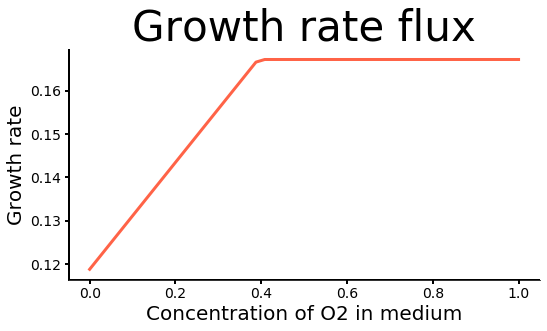

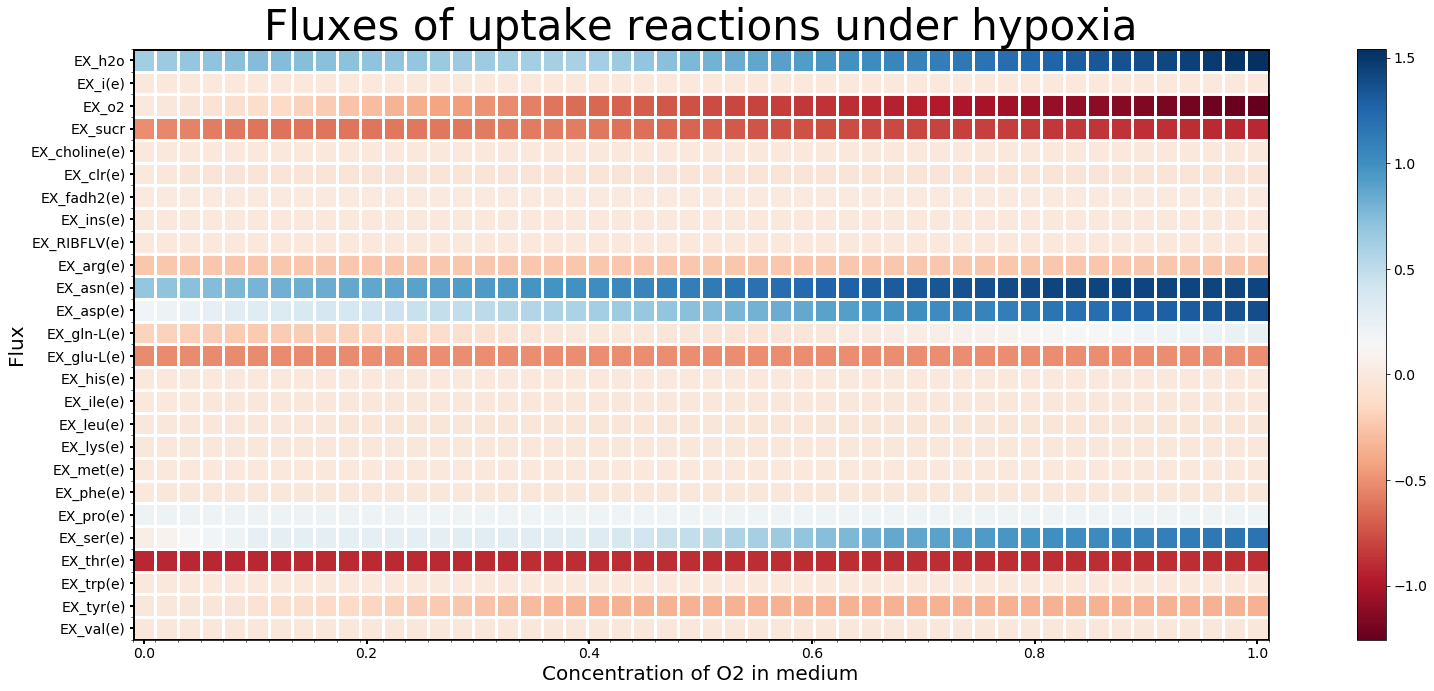

In [65]:
# Set sample size for scanning the effect of hypoxia.
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, model.medium, "BIOMASS")
hypoxia_lines(perturb, 'Growth rate', gh, 'gh_biomass_fly_medium', ylabel='Growth rate')
hypoxia_heatmap(perturb, model, 'uptake', model.medium, flux, 'gh_biomass_fly_medium', ylabel='Flux')

From the heatmap above, we only saw few uptake reactions changing along with different O2 concentration. To prove the result is not caused by zero fluxes due to the lower bound settings, we can check if there are reactions with zero value in medium.

# Compare the change of fluxes with stem-cell model

In [7]:
for ele in model.medium:
    if model.medium[ele]==0:
        print(ele, 'has zero uptake rate.')

Fortunately, it shows no metabolite that is set to zero. Thus, the response to hypoxia could be true.

In [8]:
# Import stem cell model.
stemcell = cobra.io.load_matlab_model('model_MGSA.mat')

In [9]:
# Run FBA for the simulation
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(stemcell, perturb, stemcell.medium, "biomass_objective", met='EX_o2(e)')
hypoxia_heatmap(perturb, stemcell, 'stem-cell uptake', stemcell.medium, flux,
                'gh_biomass_stem_medium', ylabel='Flux')

# check some important mets in medium like asp (they are not provided in the medium)
# compare with other famous model like Recon1

{<Reaction biomass_objective at 0x2acec5a27c10>: 1.0}

{<Reaction biomass_objective at 0x2acec6fb9370>: 1.0}

KeyError: 'BIOMASS'

The plot shows a pattern similar to the previous plot based on *Drosophila* model. To check again if there is any zero-flux reaction, we can go over the values in `medium`.

In [18]:
for ele in stemcell.medium:
    if stemcell.medium[ele]==0:
        print(ele, 'has zero uptake rate.')

for i, ele in enumerate(stemcell.medium):
    if i<11:
        print('Metabolite', ele, 'has', stemcell.medium[ele], 'uptake rate.')

Metabolite EX_ala_L(e) has 0.05 uptake rate.
Metabolite EX_arg_L(e) has 0.05 uptake rate.
Metabolite EX_asn_L(e) has 0.05 uptake rate.
Metabolite EX_asp_L(e) has 0.05 uptake rate.
Metabolite EX_btn(e) has 0.005 uptake rate.
Metabolite EX_ca2(e) has 1000.0 uptake rate.
Metabolite EX_chol(e) has 0.005 uptake rate.
Metabolite EX_cl(e) has 1000.0 uptake rate.
Metabolite EX_cys_L(e) has 0.05 uptake rate.
Metabolite EX_fe2(e) has 1000.0 uptake rate.
Metabolite EX_fol(e) has 0.005 uptake rate.


However, we noticed that the uptake rates for some important amino acid are pretty low. To get more accurate result, we swapped the medium settings to DMEMF12 that is a basal medium for stem cell culture. The lower bound value for each metabolite is recorded in the spread sheet `FINAL_MEDIUM_MAP.xlsx`.

In [19]:
medium_con = pd.read_excel('FINAL_MEDIUM_MAP.xlsx',
                           sheet_name='DMEMF12')

Here, I set the levels which have the same scale compared with uptake rate to each medium metabolite that matches the name from the table.

In [20]:
mets = medium_con['Components']
lbs = medium_con['Adjusted LB']
for ele in stemcell.medium:
    for lb, met in zip(lbs, mets):
        if met in stemcell.reactions.get_by_id(ele).name or \
        stemcell.reactions.get_by_id(ele).name in met:
            rxn = stemcell.reactions.get_by_id(ele)
            rxn.lower_bound = lb

{<Reaction biomass_objective at 0x2af06a2d5ee0>: 1.0}

{<Reaction biomass_objective at 0x2af06b762940>: 1.0}

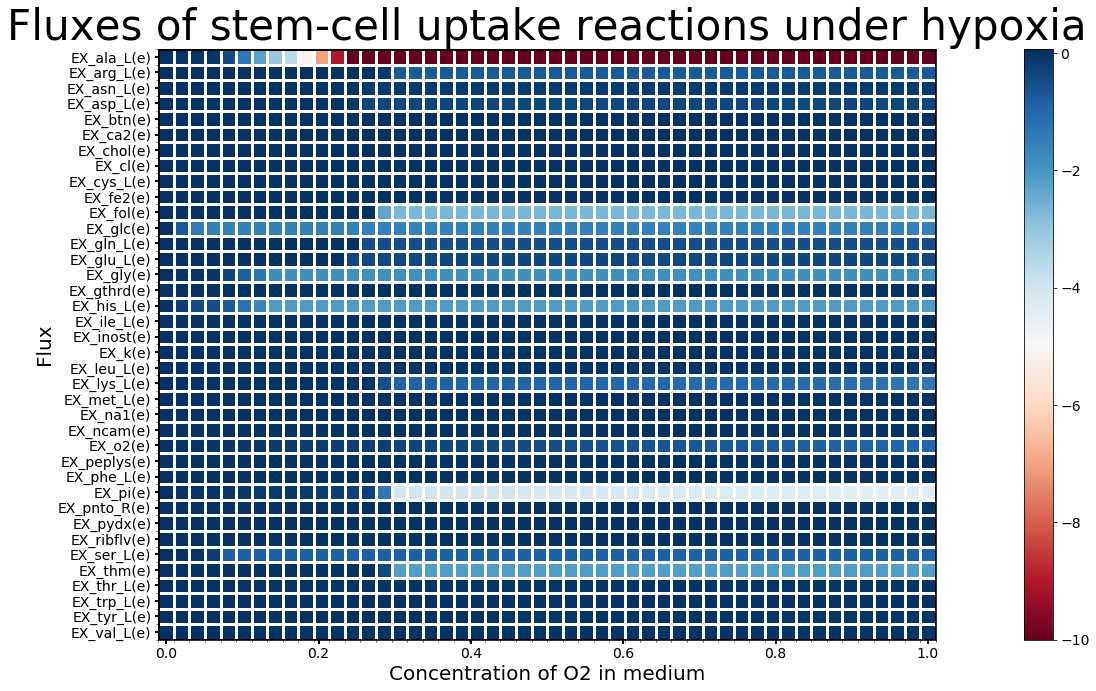

In [21]:
# Run FBA for the simulation
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(stemcell, perturb, stemcell.medium, "biomass_objective", met='EX_o2(e)')
hypoxia_heatmap(perturb, stemcell, 'stem-cell uptake', stemcell.medium,
                flux, 'DMEMF12_biomass_stem_medium', ylabel='Flux')


# Observe specific fluxes under hypoxia condition
Hypoxia could urge the embryo to switch its metabolic channel to anaerobic metabolism. To check the effect, we'd investigate the glycolysis, TCA, gln-related, asp-related and o2-related reactions under this condition. However, there is no labels in the field `Subsystems` inside the `flysilico` model. To overcome the gap, we manually searched and listed out the IDs of these reactions below.

## 1. Manual addition of each reactions

Because there is no label for reactions in the flysilico model, we grouped reactions related to glycolysis, TCA, ETC and PPP into lists respectively.

In [37]:
# IDs for glycolysis reactions
glycolysis = ['HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO',
              'PYK', 'LDH_L', 'FBP', 'G6P']
# IDs for TCA reactions
TCA = ['ME2', 'PDH', 'CS', 'ACONTa', 'ACONTb', 'ICDHyr', 'AKGDm', 'SUCOAS1m',
       'SUCD1m', 'FUM', 'MDH', 'mal_tm', 'pyr_tm']
# IDs for ETC (oxidative phosphorylation) reactions
ETC = ['ATPM', 'ATPS4r', 'PPPH', 'ppi_tm', 'adp_tm', 'NTAK', 'UFCOR', 'DPNH',
       'foc3_tm', 'FOC3CO', 'fic3_tm']
# IDs for PPP reactions
PPP = ['OXIRE', 'GLA', 'GLK', 'G6PDH2r', 'PGL', 'GND1', 'GND', 'RPI', 'RPE',
       'TKT1', 'TALA', 'TKT2', 'RBK', 'PPM', 'R1Pk', 'PhnN', 'PRPPS']

# IDs for Sucr related reactions
sucr_rxns = []
for ele in model.reactions:
    for name in ele.metabolites:
        if 'sucr' in str(name):
            sucr_rxns.append(ele.id)
            break
# IDs for GLN related reactions            
gln_rxns = []
for ele in model.reactions:
    for name in ele.metabolites:
        if 'gln' in str(name):
            gln_rxns.append(ele.id)
            break
# IDs for Tyr related reactions            
tyr_rxns = []
for ele in model.reactions:
    for name in ele.metabolites:
        if 'tyr' in str(name):
            tyr_rxns.append(ele.id)
            break
# IDs for O2 related reactions            
o2_rxns = []
for ele in model.reactions:
    tmp = []
    if ele.id =='CO2_tm' or ele.id=='CO2_t':
        continue
    else:
        for name in ele.metabolites:
            tmp.append(str(name))
        s1 = np.sum(['o2' in n for n in tmp])
        s2 = np.sum(['co2' in n for n in tmp])
        if s1==1 and s2==0:
            o2_rxns.append(ele.id)
        elif s1==2:
            o2_rxns.append(ele.id)

## 2. Glycolysis reactions
### 2.1 Drosophila

In [59]:
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, glycolysis, "BIOMASS")
hypoxia_heatmap(perturb, model, 'Glycolysis-related', glycolysis, np.ma.log(flux),
                'biomass_fly_glycolysis', ylabel='Flux')
df = pd.DataFrame(flux[:, [0,-1]])

,0,1
0,-0.985892,-1.786078
1,-0.028163,-0.039658
2,-0.384137,-1.236345
3,1.271980,2.065746
4,-0.985892,-1.786078
5,-0.028163,-0.039658
6,-0.384137,-1.236345
7,1000.000000,1000.000000
8,0.014082,0.019829
9,1000.000000,1000.000000


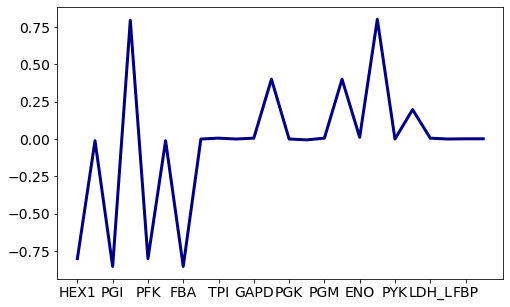

In [88]:
import seaborn as sns
v = df[1]-df[0]
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
sns.lineplot(np.arange(len(v)), v, ax=ax, color='navy')
ax.set_xticks(2*np.arange(len(glycolysis[:-1])))
ax.set_xticklabels(glycolysis[:-1])
df

In [24]:
model.reactions.get_by_id('PGK')

Reaction identifier,PGK
Name,phosphoglycerate kinase
Memory address,0x02ac5f3aec520
Stoichiometry,3pg[c] + atp[c] <=> 13dpg[c] + adp[c] 3-Phospho-D-glycerate + ATP <=> 3-Phospho-D-glyceroyl phosphate + ADP
GPR,CG3127 or CG9961
Lower bound,-1000.0
Upper bound,1000.0


### 2.2 Stem cell model

In [25]:
stem_glyco = []
for ele in stemcell.reactions:
    if 'Glycolysis' in ele.subsystem:
        stem_glyco.append(ele.id)
 

In [26]:
stem_TCA = []
for ele in stemcell.reactions:
    if 'Citric Acid Cycle' in ele.subsystem:
        stem_TCA.append(ele.id)

In [44]:
# Run FBA for the simulation
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(stemcell, perturb, stem_glyco, "biomass_objective", met='EX_o2(e)')
hypoxia_heatmap(perturb, stemcell, 'stem-cell glycolysis', stem_glyco, flux,
                'DMEMF12_biomass_stem_glycolysis', ylabel='Flux')
# run this again with mets setting
# get mets value from medium from Scott's model


NameError: name 'stemcell' is not defined

## 3. TCA reactions
### 3.1 Drosophila

{<Reaction BIOMASS at 0x2ac5fb73ce80>: 1.0}

{<Reaction BIOMASS at 0x2ac5f9637dc0>: 1.0}

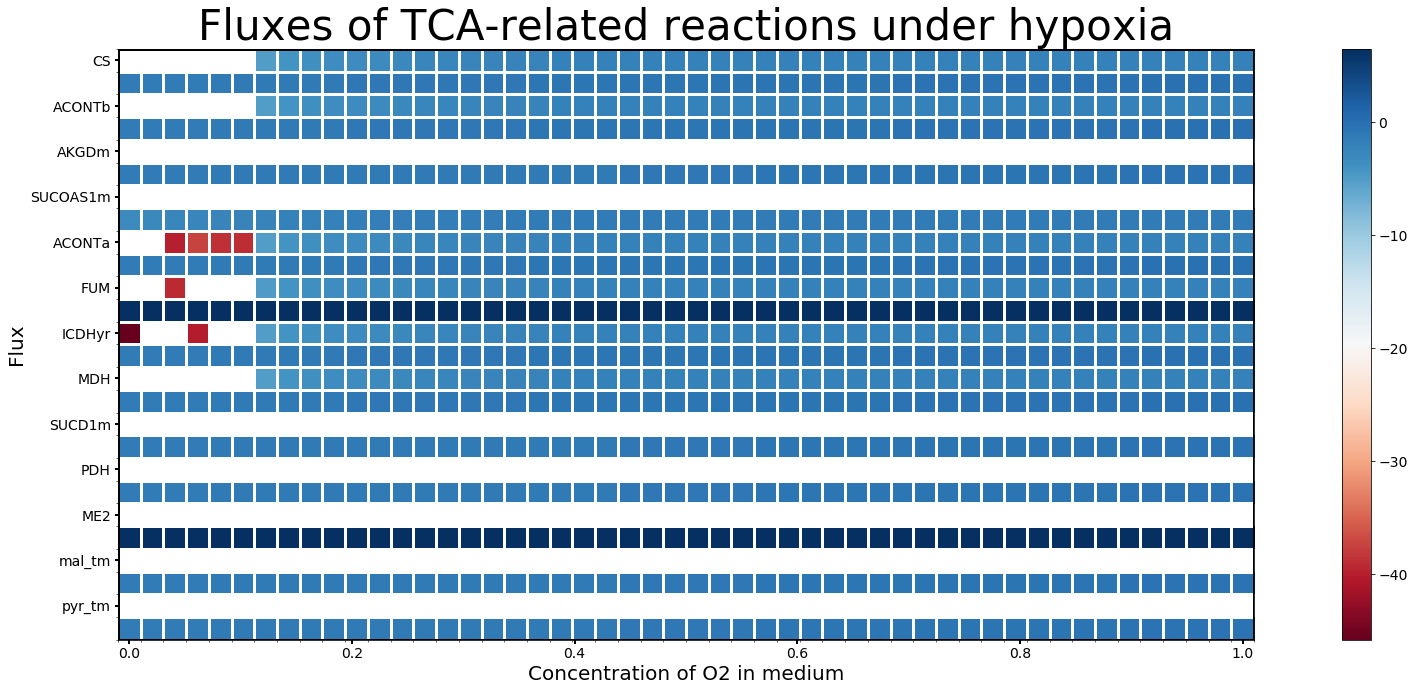

,0,1
0,0.000000e+00,0.128596
1,2.345728e-01,0.845125
2,0.000000e+00,0.128596
3,2.345728e-01,0.845125
4,0.000000e+00,0.000000
5,2.327960e-01,0.674404
6,-2.345728e-01,-0.545679
7,4.810237e-02,0.276407
8,0.000000e+00,0.128596
9,2.345728e-01,0.845125


In [89]:
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, TCA, "BIOMASS")
hypoxia_heatmap(perturb, model, 'TCA-related', TCA, np.ma.log(flux),
                'biomass_fly_TCA', ylabel='Flux')

# run FVA, PFBA again/optimizecbmodel(model, [],'one')
# Because fba only gives us one of the answers
pd.DataFrame(flux)
df = pd.DataFrame(flux[:, [0,-1]])
df

### 3.2 Stem cell

{<Reaction biomass_objective at 0x2af07182ae80>: 1.0}

{<Reaction biomass_objective at 0x2af06b762940>: 1.0}

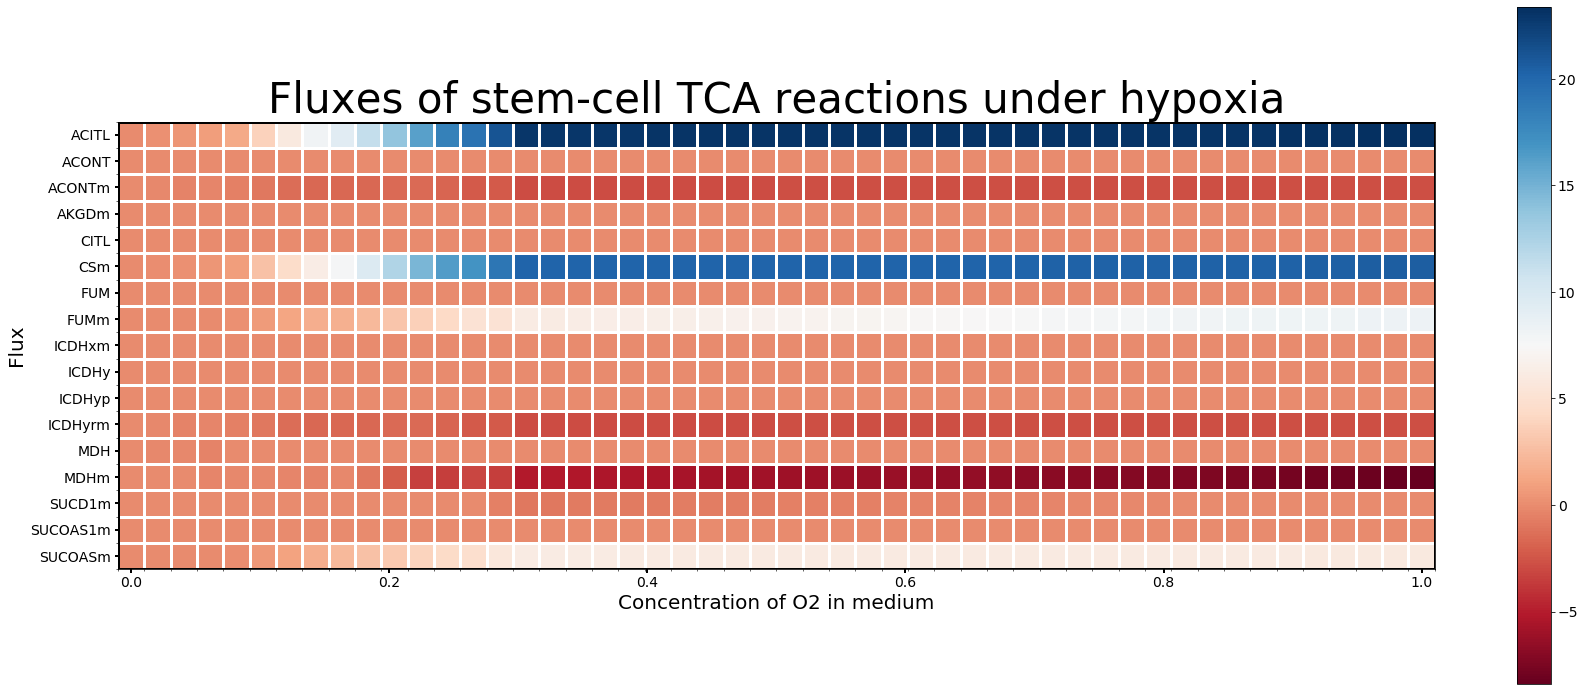

In [29]:
# Run FBA for the simulation
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(stemcell, perturb, stem_TCA, "biomass_objective", met='EX_o2(e)')
hypoxia_heatmap(perturb, stemcell, 'stem-cell TCA', stem_TCA, flux,
                'biomass_stem_TCA', ylabel='Flux')

{<Reaction BIOMASS at 0x2ac5f9e8f370>: 1.0}

{<Reaction BIOMASS at 0x2ac5f3a98f40>: 1.0}

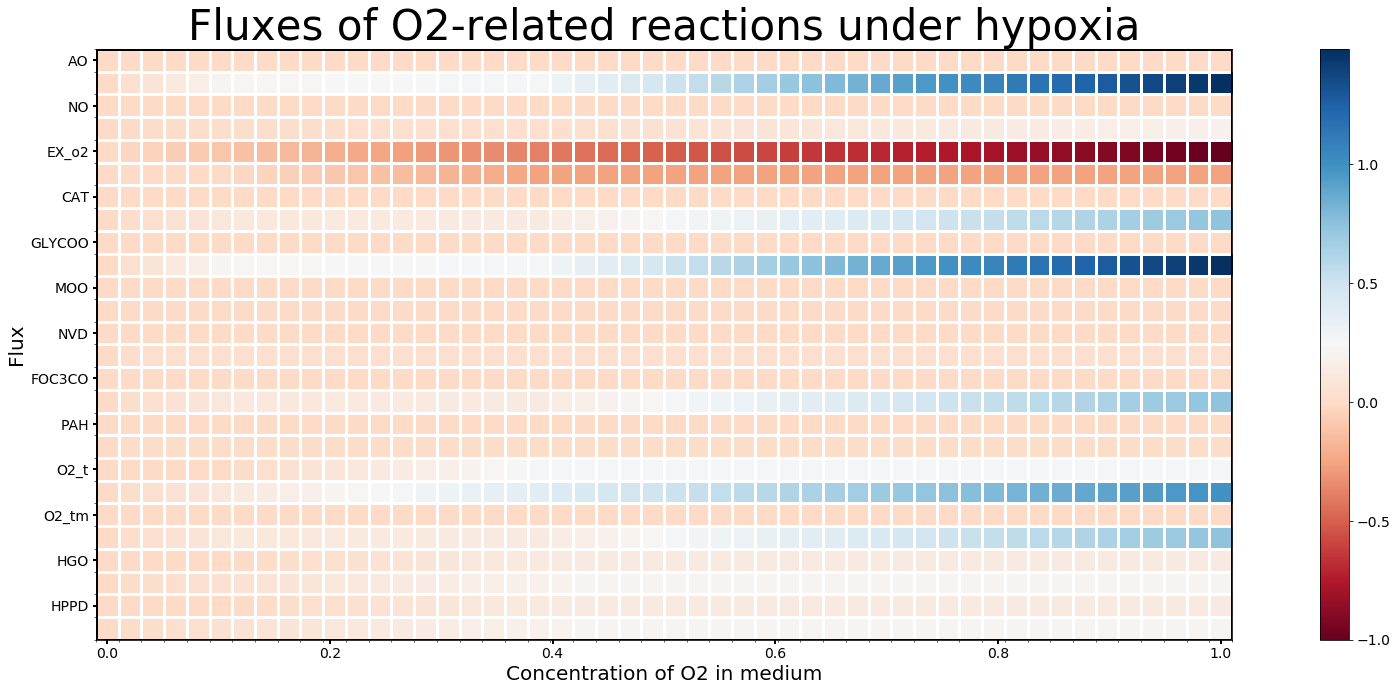

In [28]:
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, o2_rxns, "BIOMASS")
hypoxia_heatmap(perturb, model, 'O2-related', o2_rxns, flux,
                'biomass_fly_o2', ylabel='Flux')

In [31]:
display(model.reactions.get_by_id('HGO'), model.reactions.get_by_id('HPPD'))

Reaction identifier,HGO
Name,homogentisate oxygenase
Memory address,0x02af0691de280
Stoichiometry,hg[c] + o2[c] --> h[c] + maa[c] Homogentisate + O2 --> H+ + 4-Maleylacetoacetate
GPR,
Lower bound,0.0
Upper bound,1000.0


Reaction identifier,HPPD
Name,4-hydroxyphenylpyruvate dioxygenase
Memory address,0x02af0691de7f0
Stoichiometry,hpp[c] + o2[c] --> co2[c] + hg[c] 3-(4-Hydroxyphenyl)pyruvate + O2 --> CO2 + Homogentisate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [32]:
model.reactions.get_by_id('PFK').subsystem

''

In [33]:
model.metabolites.get_by_id('maa[c]')

Metabolite identifier,maa[c]
Name,4-Maleylacetoacetate
Memory address,0x02af069179640
Formula,C8H6O6
Compartment,c
In 2 reaction(s),"HGO, MAAI"


{<Reaction BIOMASS at 0x2ac5fbec61f0>: 1.0}

{<Reaction BIOMASS at 0x2ac5f9637dc0>: 1.0}

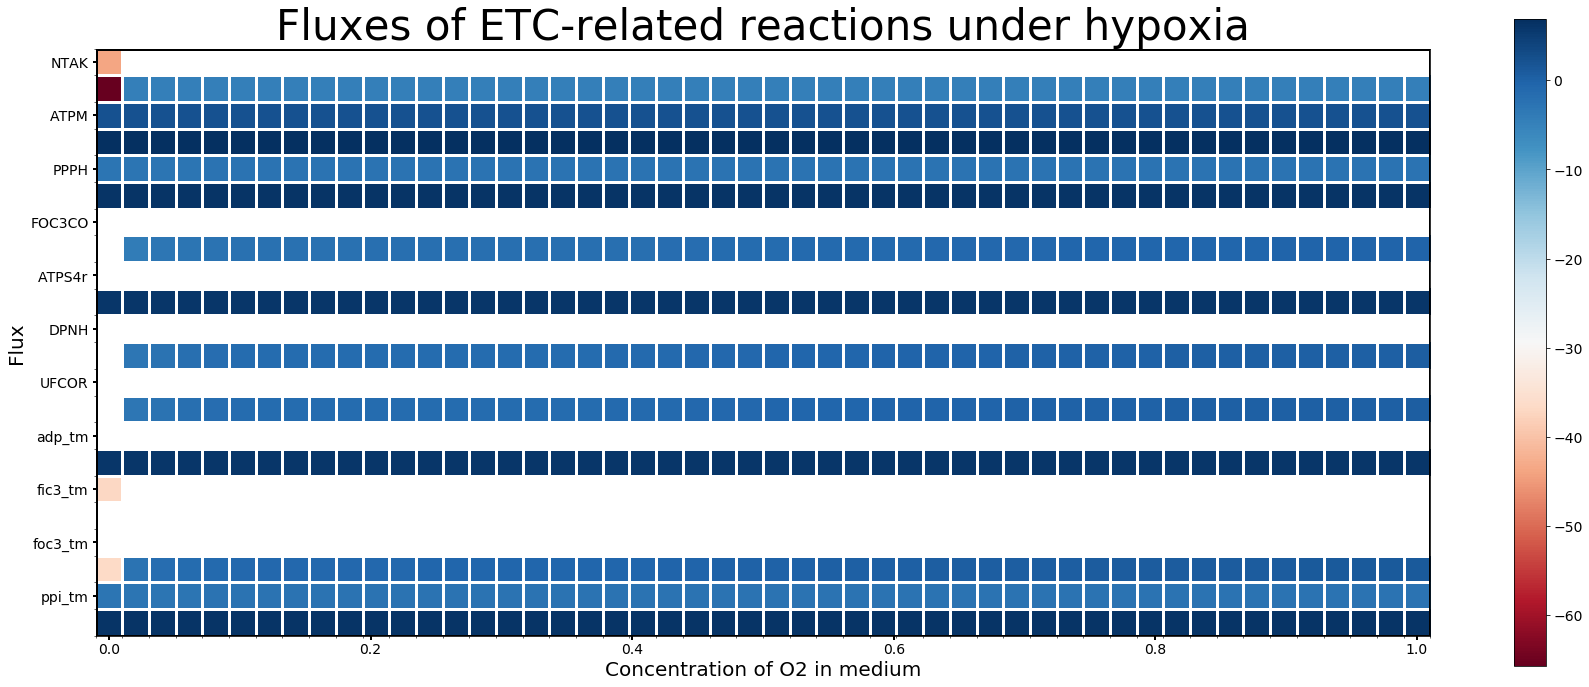

,0,1
0,1.208753e-19,0.000000
1,3.072978e-29,0.010720
2,8.550000e+00,8.550000
3,9.980045e+02,1000.000000
4,6.102863e-02,0.085938
5,5.654643e+02,566.941933
6,0.000000e+00,0.000000
7,0.000000e+00,0.742808
8,-4.997268e+02,-500.304793
9,3.304630e+02,334.825717


In [90]:
# Find id belonging to BIOMASS reactions.
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, ETC, "BIOMASS")
hypoxia_heatmap(perturb, model, 'ETC-related', ETC, np.ma.log(flux),
                'biomass_fly_ETC', ylabel='Flux')
# search asp reaction in drosophila
pd.DataFrame(flux)
df = pd.DataFrame(flux[:, [0,-1]])
df

In [35]:
display(model.reactions.get_by_id('SGH'))

Reaction identifier,SGH
Name,sucrose glucohydrolase
Memory address,0x02af0685a0880
Stoichiometry,h2o[c] + sucr[c] <=> fru[c] + glc-D[c] H2O + sucrose <=> D-Fructose + D-Glucose
GPR,CG32849 or CG7685 or CG33080 or CG14476 or CG14935 or CG14934 or CG8690 or CG11669 or CG8693 or C...
Lower bound,-1000.0
Upper bound,1000.0


{<Reaction BIOMASS at 0x2af06a140940>: 1.0}

{<Reaction BIOMASS at 0x2af069237d00>: 1.0}

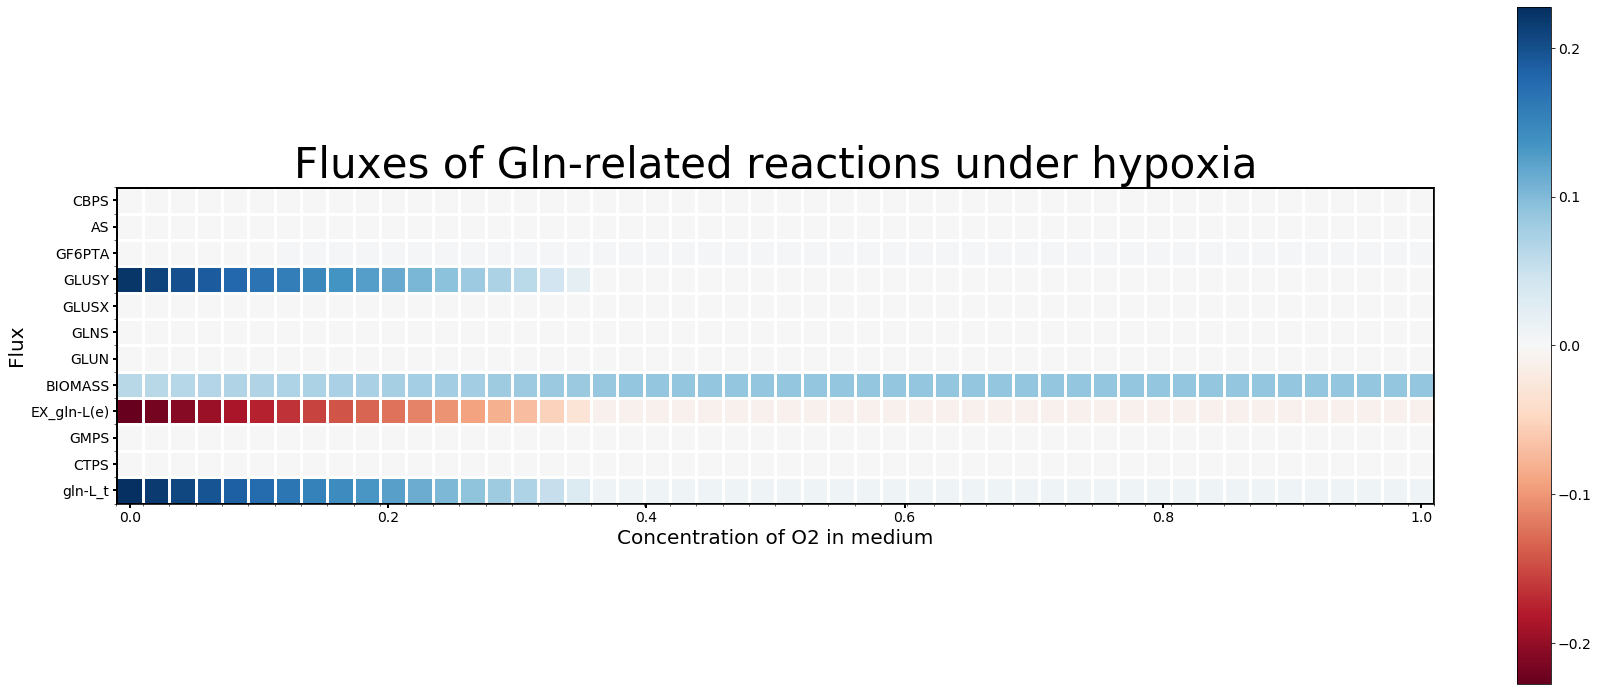

In [36]:
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, gln_rxns, "BIOMASS")
hypoxia_heatmap(perturb, model, 'Gln-related', gln_rxns, flux,
                'biomass_fly_gln', ylabel='Flux')

In [37]:
display(model.reactions.get_by_id('GLUSY')) 
# check the relation between NADH and ATP
# check metabolomics (ATP vs NADH)

Reaction identifier,GLUSY
Name,glutamate synthase (NADH)
Memory address,0x02af0691f2eb0
Stoichiometry,akg[c] + gln-L[c] + h[c] + nadh[c] --> 2.0 glu-L[c] + nad[c] 2-Oxoglutarate + L-Glutamine + H+ + Nicotinamide adenine dinucleotide - reduced --> 2.0 L-Glutamate + Nicotinamide adenine dinucleotide
GPR,
Lower bound,0.0
Upper bound,1000.0


{<Reaction BIOMASS at 0x2af07172b310>: 1.0}

{<Reaction BIOMASS at 0x2af069237d00>: 1.0}

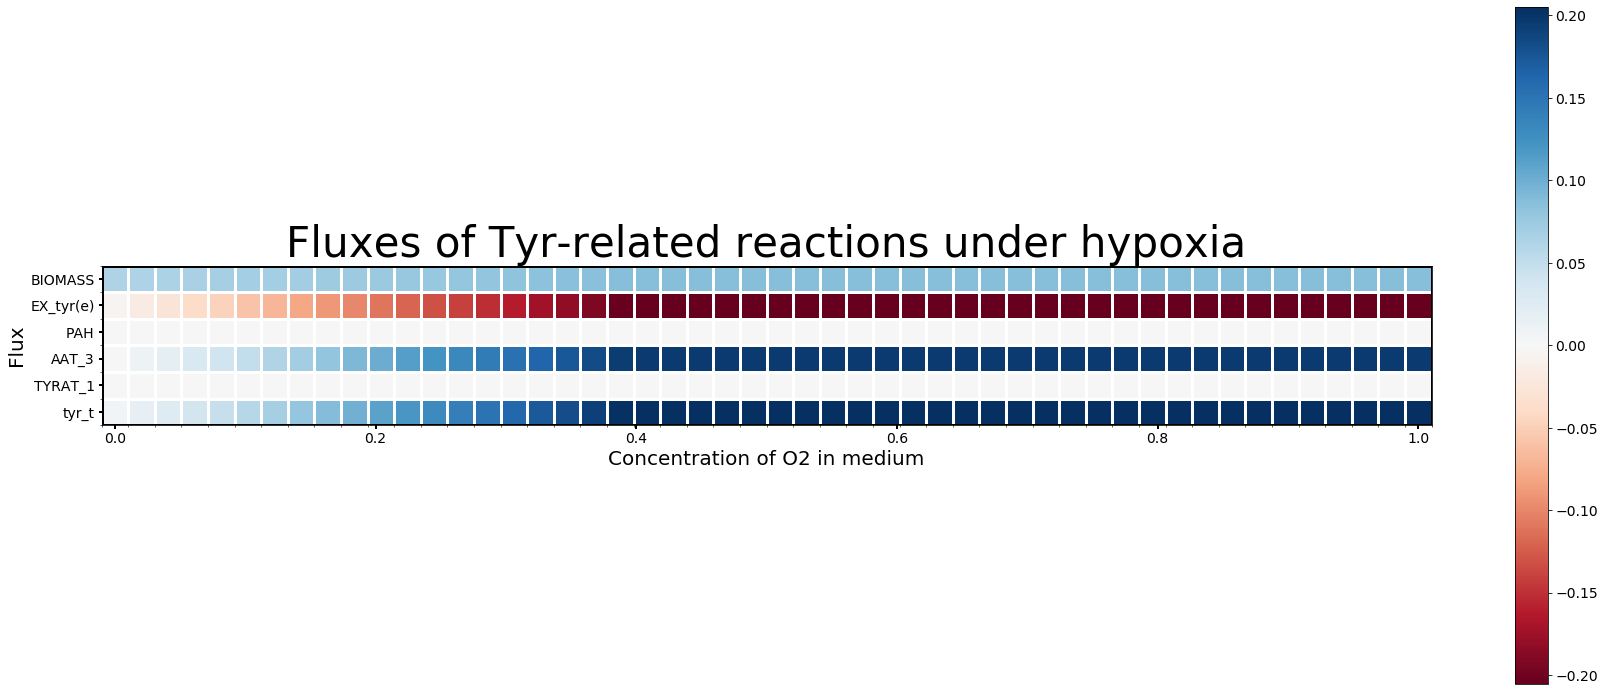

In [38]:
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, tyr_rxns, "BIOMASS")
hypoxia_heatmap(perturb, model, 'Tyr-related', tyr_rxns, flux,
                'biomass_fly_tyr', ylabel='Flux')

In [39]:
display(model.reactions.get_by_id('AAT_3'))

Reaction identifier,AAT_3
Name,aspartate transaminase[3]
Memory address,0x02af068719df0
Stoichiometry,akg[c] + tyr[c] <=> glu-L[c] + hpp[c] 2-Oxoglutarate + L-Tyrosine <=> L-Glutamate + 3-(4-Hydroxyphenyl)pyruvate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


# Growth rate of single deletions
From the articles, we have already known that some genes could affect the embryo growth in early stage like kdn, pfk, mdh, and ldh. Here, we delete every single gene and simulate the change of the growth with and without oxygen depletion.

# Reaction deletions

[144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 248, 33, 34, 35, 36, 37, 38, 39, 40, 41, 156, 250, 347, 355]


{<Reaction BIOMASS at 0x2af0729408e0>: 1.0}

{<Reaction BIOMASS at 0x2af069237d00>: 1.0}

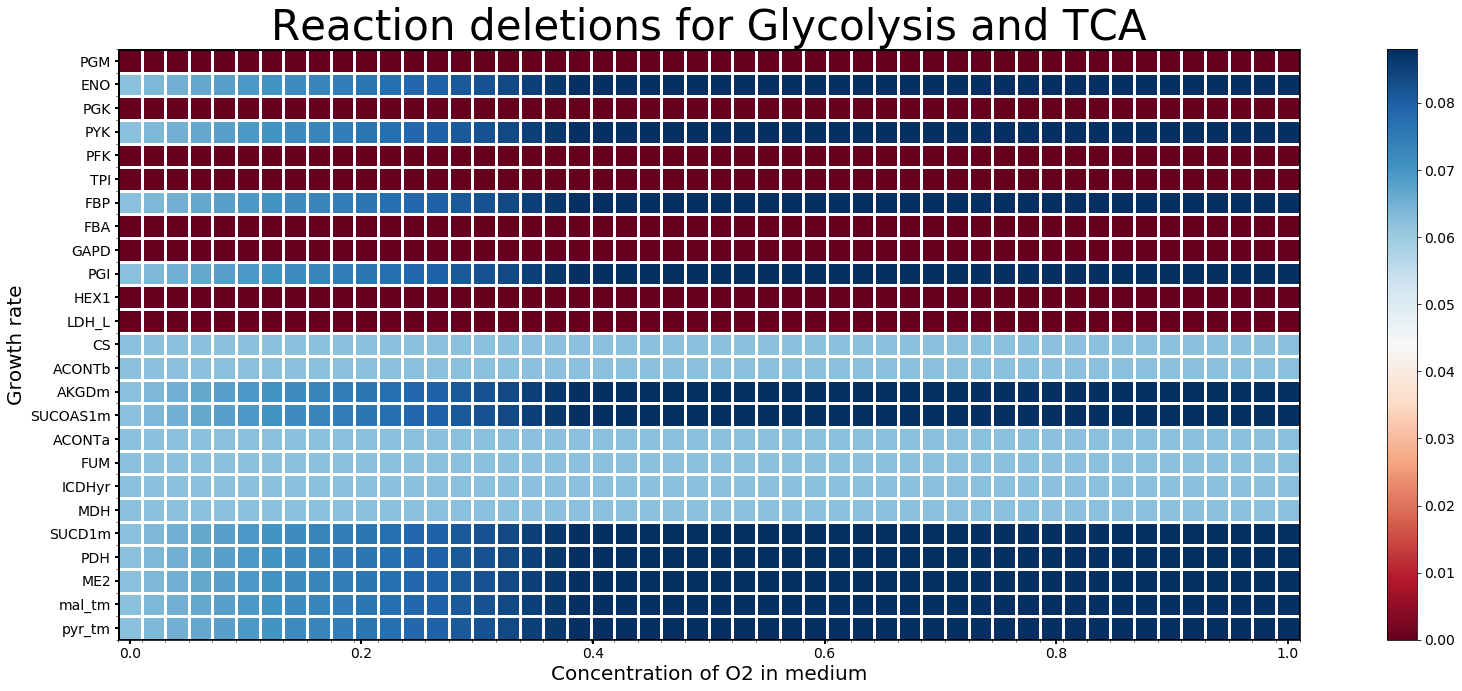

In [42]:
# Find id belonging to BIOMASS reactions.
gly = [i for i in range(len(model.reactions)) if model.reactions[i].id in glycolysis]
tca = [i for i in range(len(model.reactions)) if model.reactions[i].id in TCA]
ids = gly+tca
print(ids)
# Settings for the model
tmp5_m = model.copy()
tmp5_m.objective = "BIOMASS"
display(linear_reaction_coefficients(tmp5_m))
display(linear_reaction_coefficients(model))
# Set sample size for scanning the effect of hypoxia.
sample_size = 50
pertub = np.linspace(0, 1, sample_size)
# Create empty matrix to record results by optimizing growth rate.
flux = np.zeros((len(ids), sample_size))
# Perturbation.
for i, con in enumerate(pertub):
    # Change concentration of oxygen from medium.
    medium = tmp5_m.medium
    medium['EX_o2'] = con
    tmp5_m.medium = medium
    # Optimization for growth rate.
    res = single_reaction_deletion(tmp5_m, tmp5_m.reactions)
    
    ylabel = []
    for ii in ids:
        rxn = tmp5_m.reactions[ii].id
        for jj, name in enumerate(res.index):
            if rxn==str(name)[12:-3]:
                ylabel.append(jj)
    flux[:, i] = res.iloc[ylabel]['growth'].to_numpy()

fig = plt.figure(figsize=(25, 10))
ax5 = fig.add_subplot(111)
im = ax5.imshow(flux, cmap='RdBu')
ax5.set_yticks(range(len(ids)))
# ax5.set_yticklabels(model.reactions[ids])
ax5.set_yticklabels([tmp5_m.reactions[i].id for i in ids])
ax5.set_xticks(np.linspace(0, sample_size-1, 6))
ax5.set_xticklabels(np.round(np.linspace(0, 1, 6), 3))
ax5.set_ylabel('Growth rate')
ax5.set_xlabel('Concentration of O2 in medium')
ax5.set_title('Reaction deletions for Glycolysis and TCA')
CanvasStyle(ax5, square=True)
ax5.set_xticks(np.arange(flux.shape[1]+1)-.5, minor=True)
ax5.set_yticks(np.arange(flux.shape[0]+1)-.5, minor=True)
ax5.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.colorbar(im)
plt.tight_layout()
plt.show()

[144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 248, 33, 34, 35, 36, 37, 38, 39, 40, 41, 156, 250, 347, 355]


{<Reaction atp_measure at 0x2af073342460>: 1.0}

{<Reaction BIOMASS at 0x2af069237d00>: 1.0}

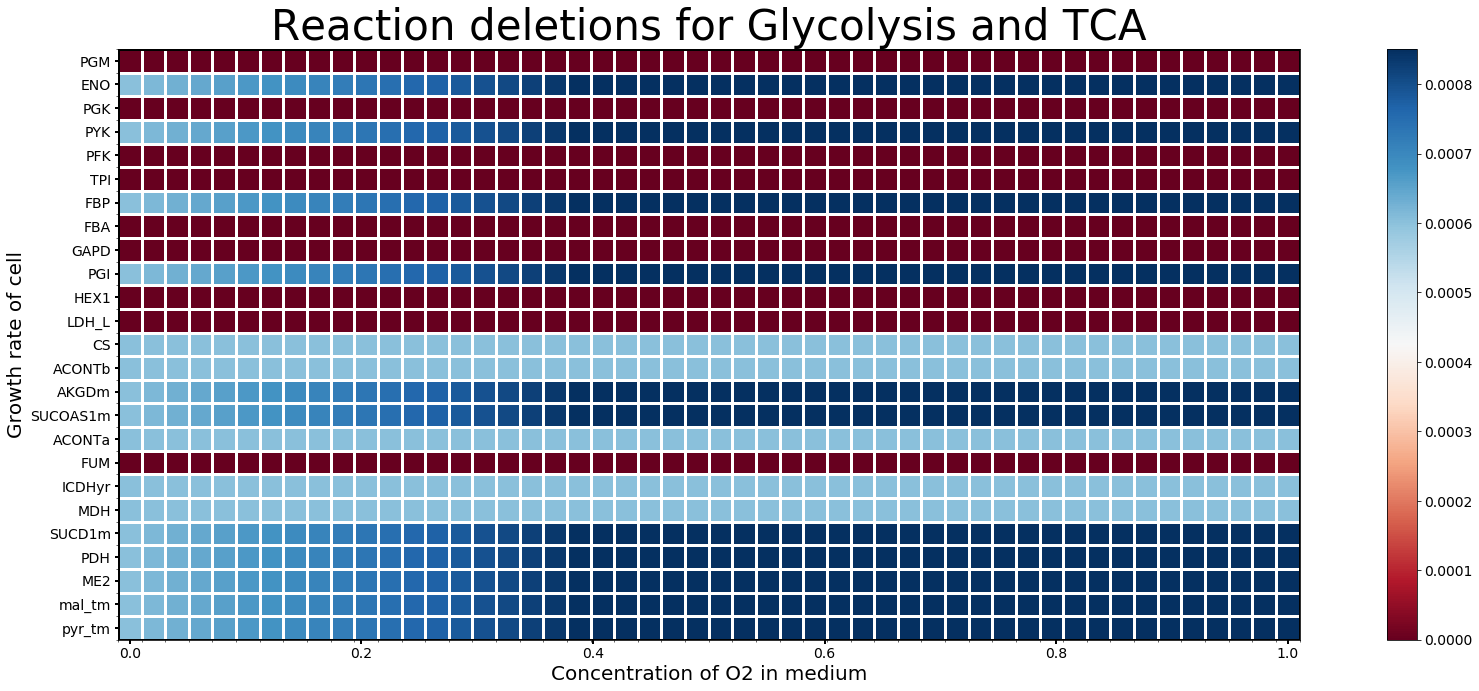

In [43]:
# Find id belonging to BIOMASS reactions.
gly = [i for i in range(len(model.reactions)) if model.reactions[i].id in glycolysis]
tca = [i for i in range(len(model.reactions)) if model.reactions[i].id in TCA]
ids = gly+tca
print(ids)
# Settings for the model
tmp5_m = fly.copy()
tmp5_m.objective = "atp_measure" # modify it!!
# ATP[c] --> 
display(linear_reaction_coefficients(tmp5_m))
display(linear_reaction_coefficients(model))
# Set sample size for scanning the effect of hypoxia.
sample_size = 50
pertub = np.linspace(0, 1, sample_size)
# Create empty matrix to record results by optimizing growth rate.
flux = np.zeros((len(ids), sample_size))
# Perturbation.
for i, con in enumerate(pertub):
    # Change concentration of oxygen from medium.
    medium = tmp5_m.medium
    medium['EX_o2'] = con
    tmp5_m.medium = medium
    # Optimization for growth rate.
    res = single_reaction_deletion(tmp5_m, tmp5_m.reactions)
    
    ylabel = []
    for ii in ids:
        rxn = tmp5_m.reactions[ii].id
        for jj, name in enumerate(res.index):
            if rxn==str(name)[12:-3]:
                ylabel.append(jj)
    flux[:, i] = res.iloc[ylabel]['growth'].to_numpy()

fig = plt.figure(figsize=(25, 10))
ax5 = fig.add_subplot(111)
im = ax5.imshow(flux, cmap='RdBu')
ax5.set_yticks(range(len(ids)))
# ax5.set_yticklabels(model.reactions[ids])
ax5.set_yticklabels([tmp5_m.reactions[i].id for i in ids])
ax5.set_xticks(np.linspace(0, sample_size-1, 6))
ax5.set_xticklabels(np.round(np.linspace(0, 1, 6), 3))
ax5.set_ylabel('Growth rate of cell')
ax5.set_xlabel('Concentration of O2 in medium')
ax5.set_title('Reaction deletions for Glycolysis and TCA')
CanvasStyle(ax5, square=True)
ax5.set_xticks(np.arange(flux.shape[1]+1)-.5, minor=True)
ax5.set_yticks(np.arange(flux.shape[0]+1)-.5, minor=True)
ax5.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [100]:
all_list = [ele.id for ele in model.reactions if 'EX' not in ele.id
            and 'tm' not in ele.id and '_t' not in ele.id]

# Set sample size for scanning the effect of hypoxia.
sample_size = 50
perturb = np.linspace(0, 1, sample_size)
gh, flux = exp_change_medium(model, perturb, all_list, "BIOMASS")
df = pd.DataFrame(data=flux)
df.index = all_list
df.columns = np.round(perturb, 2)

{<Reaction BIOMASS at 0x2af083064580>: 1.0}

{<Reaction BIOMASS at 0x2af069237d00>: 1.0}

In [101]:
import seaborn as sns

<Figure size 1440x720 with 0 Axes>

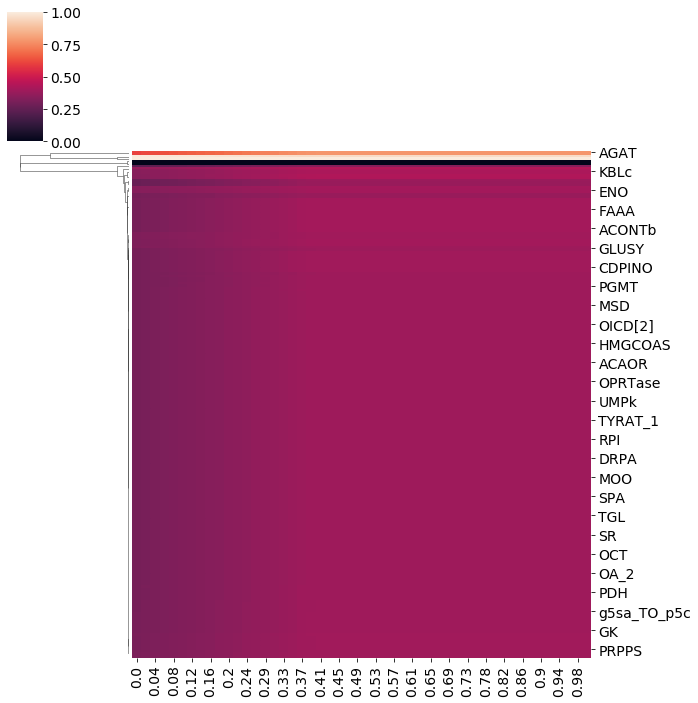

In [102]:
fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(111)
clustergrid = sns.clustermap(df, col_cluster=False, standard_scale=1, method="single")#.fig.suptitle('')

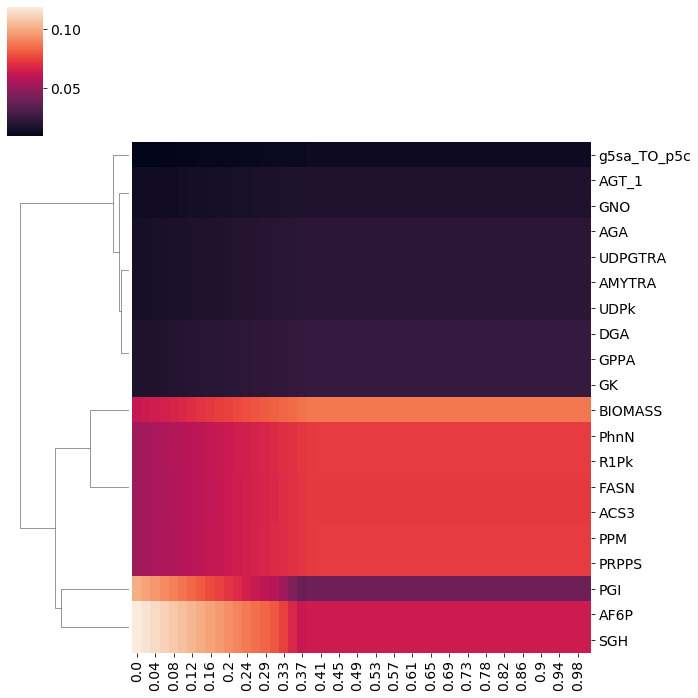

In [103]:
topind = clustergrid.dendrogram_row.reordered_ind[-20:]
clusterplot = sns.clustermap(df.iloc[topind], col_cluster=False, method="single")
clusterplot.savefig("last20Hypoxiaclustermap.png")